In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
%matplotlib notebook

In [170]:
dataset = pd.read_csv('downloads/train.csv') # reading the training data

In [171]:
data = dataset.copy() #so we can retrieve original data anytime, .copy takes different space in memory

In [172]:
data.head() #display top 5 records

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration

In [6]:
data.isnull().sum().sort_values(ascending=False) #finding the number of missing values in each category

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [7]:
catcol = [col for col in data.columns if data[col].dtypes == 'O'] # categorical or object type features
numcol = [col for col in data.columns if col not in catcol] # numerical features
print(catcol,numcol)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [8]:
for col in catcol:
    print(col,'has',len(data[col].unique()),'different categories')   # finding the amount of unique categories 

Name has 891 different categories
Sex has 2 different categories
Ticket has 681 different categories
Cabin has 148 different categories
Embarked has 4 different categories


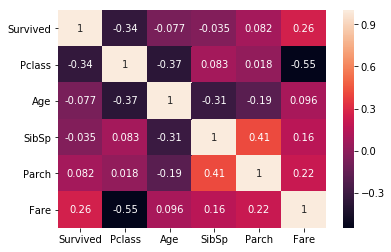

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(data.drop('PassengerId',axis=1).corr(),annot=True)

It is observed that there is a strong relationship between survival and passenger class, 
also a correlation between sibling-spouse and parents-children features,
there is a strong linking between passenger class and age also,
Fare as we might safely guess is highly correlated to the passenger class.

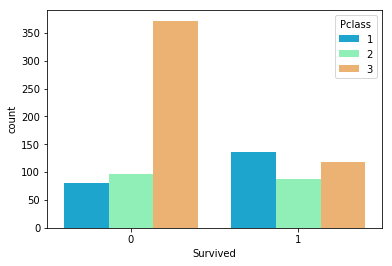

In [20]:
#data.groupby('Pclass')['Survived'].mean().plot.bar()
plt.xlabel('Passenger Class')
plt.ylabel('Survived') 
sns.countplot(x='Survived',hue='Pclass',data=data,palette='rainbow')
# It is observed there is a clear demarkation in the survival rates with respect to class of passenger

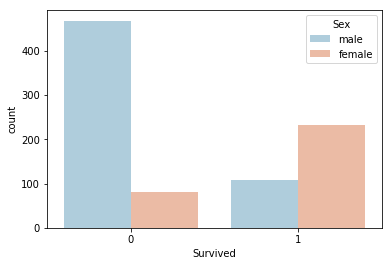

In [18]:
sns.countplot(x='Survived',hue='Sex',data=data,palette='RdBu_r')
# There is a huge demarkation btw % of men and women that surived

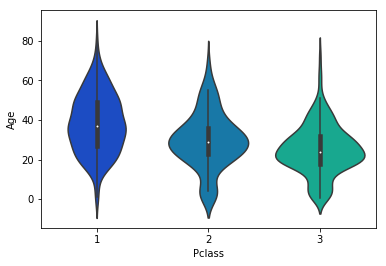

In [14]:
x =sns.violinplot(x='Pclass',y='Age',data=data,palette='winter')
#it is observed that the mean age of a passenger increases as the passenger class is inmporved, thus pclass will 
#an important parameter to determine the missing ages, along with gender

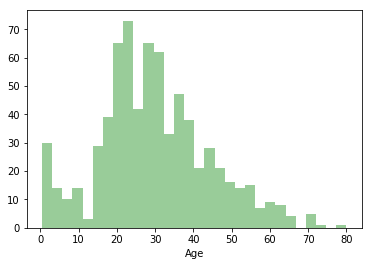

In [22]:
sns.distplot(data['Age'].dropna(),kde=False,color='green',bins=30)

In [25]:
print('Skew: {} and Kurtosis : {}'.format(data.Fare.skew(),data.Fare.kurt()))
# This shows that the fare data is highly skewed hence we may apply log transformation to make it fit normal distribution

Skew: 4.787316519674893 and Kurtosis : 33.39814088089868


In [27]:
for col in numcol:
    print('For {} Skew: {} and Kurtosis : {}'.format(col,data[col].skew(),data[col].kurt()))
# Sibsp and Parch can be refined further

For PassengerId Skew: 0.0 and Kurtosis : -1.1999999999999997
For Survived Skew: 0.4785234382949897 and Kurtosis : -1.775004671066304
For Pclass Skew: -0.6305479068752845 and Kurtosis : -1.2800149715782825
For Age Skew: 0.38910778230082704 and Kurtosis : 0.17827415364210353
For SibSp Skew: 3.6953517271630565 and Kurtosis : 17.880419726645968
For Parch Skew: 2.7491170471010933 and Kurtosis : 9.778125179021648
For Fare Skew: 4.787316519674893 and Kurtosis : 33.39814088089868


In [29]:
data['Cab'] = data.Cabin.str.extract('([A-Z]+)')

In [30]:
data.Cab.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [31]:
data.Cab = data.Cab.replace(np.nan,'N') #converting none values to a N category

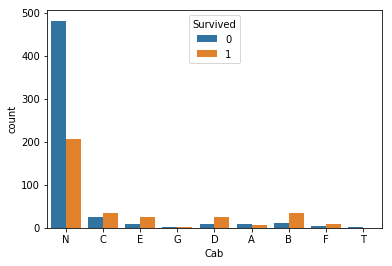

In [39]:
sns.countplot(x='Cab',hue='Survived',data=data) # ignoring the difference of scales it should be observed that
#classes C,E,D,B,F have more numer of survived cases as compared to others

# Data Cleaning and Feature Engineering

In [40]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Cab              0
dtype: int64

In [41]:
#we'll simply fill the embarked by the mode of the data since they are only 2
data.Embarked = data.Embarked.fillna(data.Embarked.mode()[0])

In [42]:
#Cab feature has been extracted from cabin and hence can be dropped
#Age has dependancy on Pclass thus we'll fill them wrt pclass , it slightly varies with sex as well
data.Age = data.groupby(['Pclass','Sex'])['Age'].apply(lambda x:x.fillna(x.median()))

In [43]:
data = data.drop('Cabin',axis=1)

In [47]:
data.isna().sum().tolist() # all missing values have been filled

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
# SibSp and Parch can be essentially converted into just 1 feature ie Family members
data['Family'] = data.SibSp + data.Parch + 1 # +1 so that if he is alone, atleast 1 mumber in family

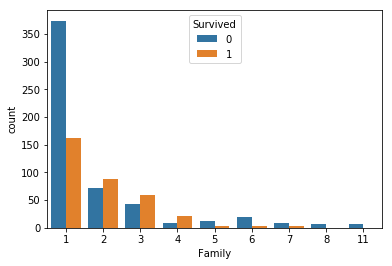

In [49]:
sns.countplot(x='Family',hue='Survived',data=data)
# it is observed that alone person is most likely to die, and people with families bigger than 4 also likely die
#thus we can make a new feature to indicate if a person is alone

In [50]:
data['Alone'] = 0
data.loc[ data['Family'] > 1 , 'Alone' ] = 1

In [57]:
# From the names, the titles can be found which may help in strenghtening the analysis
data['Title'] = data.Name.str.extract('([A-za-z]+)\.')

In [74]:
data.groupby('Title')['Survived'].sum()
#Mr,Master,Miss,Mrs are the only major titles, others can be converted into rare

Title
Capt          0
Col           1
Countess      1
Don           0
Dr            3
Jonkheer      0
Lady          1
Major         1
Master       23
Miss        127
Mlle          2
Mme           1
Mr           81
Mrs          99
Ms            1
Rev           0
Sir           1
Name: Survived, dtype: int64

In [79]:
# making titles category less populated
common = ['Master','Miss','Mr','Mrs']
rare = [x for x in data.Title.unique().tolist() if x not in common]
data.Title = data.Title.replace(rare,'Rare')

In [80]:
data.Title = data.Title.replace(['Miss','Ms'],'Mrs')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

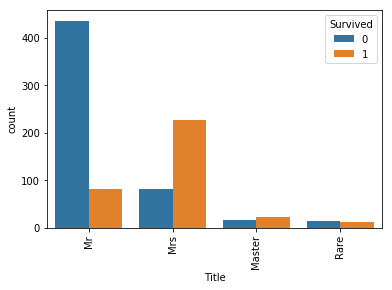

In [81]:
# Plotting to see title vs surival
sns.countplot(x='Title',hue='Survived',data=data)
plt.xticks(rotation=90)

In [87]:
# experimenting with different categorical variables whether label encoding will be better or one hot encoding
data['LabTitle'] = LabelEncoder().fit_transform(data.Title)
data['LabSex'] = LabelEncoder().fit_transform(data.Sex)

In [90]:
data.LabTitle.corr(data.Survived)

0.38811468354876394

In [91]:
data.LabSex.corr(data.Survived)

-0.5433513806577552

In [92]:
sex = pd.get_dummies(data.Sex)

In [98]:
for i in sex:
    print(sex[i].corr(data.Survived))

0.5433513806577552
-0.5433513806577552


In [111]:
data['em'] = LabelEncoder().fit_transform(data.Embarked)
data['tit'] = LabelEncoder().fit_transform(data.Title)

In [114]:
tit = pd.get_dummies(data.Title)
for i in tit:
    print(tit[i].corr(data.Survived))
print('-'*20)
print(data.tit.corr(data.Survived))

0.08522056083929429
-0.5491991849030085
0.5252620634185607
0.02203025607922676
--------------------
0.38811468354876394


In [103]:
em = pd.get_dummies(data.Embarked)
for i in em:
    print(em[i].corr(data.Survived))

0.16824043121823326
0.0036503826839721734
-0.1496827232706856


In [102]:
data.em.corr(data.Survived)

-0.1676753138677214

In [105]:
x = 0.1682404+0.003650+0.1498272
x/3

0.10723919999999999

In [ ]:
#thus we choose labelencoding for this dataset as it gives better correlation

In [109]:
catcol = [feature for feature in data.columns if data[feature].dtypes == 'O']

In [156]:
data = data.drop(['Name','Ticket'],axis=1)

In [115]:
#label encoding numbering the catergories of each categorical feature
data.Sex = LabelEncoder().fit_transform(data.Sex) 
data.Embarked = LabelEncoder().fit_transform(data.Embarked)
data.Cab = LabelEncoder().fit_transform(data.Cab)
data.Title = LabelEncoder().fit_transform(data.Title)

In [157]:
data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,7.8292,NaN,Q
1,893,3,female,47.0,1,0,7.0000,NaN,S
2,894,2,male,62.0,0,0,9.6875,NaN,Q
3,895,3,male,27.0,0,0,8.6625,NaN,S
4,896,3,female,22.0,1,1,12.2875,NaN,S


In [129]:
data = data.drop('PassengerId',axis=1)

In [119]:
data = data.drop(['LabTitle','LabSex','em','tit'],axis=1) # dropping the unnecesary columns

In [139]:
# scaling is an important part of preprocessing, we will observe results acc to both
datam = MinMaxScaler().fit_transform(data)
datas = StandardScaler().fit_transform(data)

D:\tanay\anaconda\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\tanay\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\tanay\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [155]:
datas = pd.DataFrame(datas)
datam = pd.DataFrame(datam)

#datas.head()

In [154]:
#plt.figure(figsize=(10,10))
#plt.subplot(311)
#sns.heatmap(data.corr(),annot=True)
#plt.subplot(312)
#sns.heatmap(datam.corr(),annot=True)
#plt.subplot(313)
#sns.heatmap(datas.corr(),annot=True)

In [175]:
data.to_csv('traindf.csv')
train = data.copy()

# Do the same process for test data

In [166]:
#importing test csv
test = pd.read_csv('downloads/test.csv')
data = test.copy()

In [173]:
# all the preprocessing techniques performed for test data, name is kept same for use in both 
data['Cab'] = data.Cabin.str.extract('([A-Z]+)') # getting 1st alphabet of cabin
data.Cab = data.Cab.replace(np.nan,'N') #converting none values to a N category
data.Embarked = data.Embarked.fillna(data.Embarked.mode()[0]) # filling embarked with S
data.Age = data.groupby(['Pclass','Sex'])['Age'].apply(lambda x:x.fillna(x.median())) #filling missing values of age
data = data.drop('Cabin',axis=1)
data['Family'] = data.SibSp + data.Parch + 1  # feature generation
data['Alone'] = 0
data.loc[ data['Family'] > 1 , 'Alone' ] = 1
data['Title'] = data.Name.str.extract('([A-za-z]+)\.') # refining name feature
common = ['Master','Miss','Mr','Mrs']    # most common titles
rare = [x for x in data.Title.unique().tolist() if x not in common]
data.Title = data.Title.replace(rare,'Rare') 
data.Title = data.Title.replace(['Miss','Ms'],'Mrs')
data = data.drop(['Name','Ticket'],axis=1)
data.Sex = LabelEncoder().fit_transform(data.Sex)      # making catergorical features numerical
data.Embarked = LabelEncoder().fit_transform(data.Embarked)
data.Cab = LabelEncoder().fit_transform(data.Cab)
data.Title = LabelEncoder().fit_transform(data.Title)
data = data.drop('PassengerId',axis=1)

In [169]:
testdf = data.copy()

In [176]:
testdf.to_csv('testdf.csv')

In [177]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cab,Family,Alone,Title
0,0,3,1,22.0,1,0,7.2500,2,7,2,1,1
1,1,1,0,38.0,1,0,71.2833,0,2,2,1,2
2,1,3,0,26.0,0,0,7.9250,2,7,1,0,2
3,1,1,0,35.0,1,0,53.1000,2,2,2,1,2
4,0,3,1,35.0,0,0,8.0500,2,7,1,0,1


In [178]:
testdf.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cab,Family,Alone,Title
0,3,1,34.5,0,0,7.8292,1,7,1,0,1
1,3,0,47.0,1,0,7.0000,2,7,2,1,2
2,2,1,62.0,0,0,9.6875,1,7,1,0,1
3,3,1,27.0,0,0,8.6625,2,7,1,0,1
4,3,0,22.0,1,1,12.2875,2,7,3,1,2


# Modelling

In [181]:
df = pd.read_csv('traindf.csv')
X = df.drop('Survived',axis=1)
y = df['Survived']

In [283]:
Xtest = pd.read_csv('testdf.csv')
Xtest.isna().sum()

Unnamed: 0    0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          1
Embarked      0
Cab           0
Family        0
Alone         0
Title         0
dtype: int64

In [284]:
Xtest.Fare = Xtest.groupby('Pclass').Fare.fillna(Xtest.Fare.median())

In [185]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 0) #split

In [225]:
# testing before gridsearchcv
clf = RandomForestClassifier(n_estimators =100,random_state=0,max_features=11,max_depth=11).fit(xtrain, ytrain)
pred = clf.predict(xtest)
f1_score(ytest,pred)

0.7741935483870968

In [252]:
# defining the parameter grid to be tested during grid search
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 9, 10, 11],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [253]:
# Defining the grid search model
mod = GridSearchCV(estimator = RandomForestClassifier(), param_grid=param_grid, scoring='roc_auc',
                   cv=3, verbose=2,refit=True)

In [254]:
mod.fit(xtrain,ytrain)  # fitting the model based on the results from grid search

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=

[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=

[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=

[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=

[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=

[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=8, max_features=3, min_samples_leaf=

[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=

[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=

[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=

[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=

[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=

[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=9, max_features=3, min_samples_leaf=

[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.2s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.2s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.1s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.0s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.2s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.2s
[CV] bootstrap=True, max_depth=11, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=11, max_features=3, min_samp

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:  6.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True], 'max_depth': [8, 9, 10, 11], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [255]:
mod.best_params_    # looking for the best parameters for the Random Forest Classifier

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

In [276]:
# Training the model based on the best fit Hyperparameter Tuning 
clf = RandomForestClassifier(n_estimators =300,random_state=0,max_features=10,max_depth=8,min_samples_leaf=5,
                             min_samples_split=7).fit(xtrain, ytrain)
pred = clf.predict(xtest)
f1_score(ytest,pred)

0.7848101265822786

In [277]:
# Test data
Xtest = pd.read_csv('testdf.csv')

In [292]:
# Training the model on the whole of Train Data and taking predictions for the entire Test csv
clf = RandomForestClassifier(n_estimators =300,random_state=0,max_features=10,max_depth=8,min_samples_leaf=5,
                             min_samples_split=7).fit(X,y)
pred = clf.predict(Xtest)


In [293]:
# Saving Ouput as csv based on the instructions given
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred})
output.to_csv('my_submission.csv', index=False)